Note:  This notebook has widgets to select the state, congressional district and facility.  Those currently work only when the cells are run one at a time sequentially, not all at once.

## Resource Conservation and Recovery Act Violations by Congressional District

This notebook examines ECHO data using ECHO_EXPORTER, RCRA_FACILITIES,
and RCRA_VIOLATIONS.

From ECHO_EXPORTER:
<ul>
    <li>RCRA_IDS - to match facilities/violations in RCRA_FACILITIES and RCRA_VIOLATIONS</li>
    <li>FAC_DERIVED_CD113 - 113th congressional district</li>
    <li>FAC_LAT and FAC_LONG - latitude and longitude</li>
    <li>RCRA_PERMIT_TYPES</li>
</ul>

RCRA Permit Types include:
<ul>
    <li>TSDF = Treatment, Storage and Disposal facility</li>
    <li>LQG = Large Quantity Generator</li>
    <li>SQG = Small Quantity Generator</li>
    <li>CESQG = Conditionally-Exempt Small Quantity Generator</li>
</ul>


A state and congressional district must be chosen using the dropdown
widgets that are provided.

In [1]:
# Import libraries
import urllib.parse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import folium

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display


Run this next cell, select a state, and then run the following cell.

In [2]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
dropdown_state=widgets.Dropdown(
    options=states,
    value='NY',
    description='State:',
    disabled=False,
)
output_state = widgets.Output()
my_state = ""

def dropdown_state_eventhandler( change ):
    output_state.clear_output()
    value = change.new
    with output_state:
        display( change.new )
            
dropdown_state.observe( dropdown_state_eventhandler, names='value')
display( dropdown_state )

Dropdown(description='State:', index=32, options=('AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', …

Run this next cell after choosing a state from the dropdown list.

In [3]:
my_state = dropdown_state.value

sql = "select FAC_NAME, FAC_LAT, FAC_LONG, RCRA_IDS, " + \
    "RCRA_PERMIT_TYPES, FAC_DERIVED_CD113 from ECHO_EXPORTER where RCRA_FLAG = 'Y'" + \
    "and FAC_STATE = '" + my_state + "'" 
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)
print(sql)
print(data_location)

select FAC_NAME, FAC_LAT, FAC_LONG, RCRA_IDS, RCRA_PERMIT_TYPES, FAC_DERIVED_CD113 from ECHO_EXPORTER where RCRA_FLAG = 'Y'and FAC_STATE = 'NC'
http://apps.tlt.stonybrook.edu/echoepa/?query=select%20FAC_NAME%2C%20FAC_LAT%2C%20FAC_LONG%2C%20RCRA_IDS%2C%20RCRA_PERMIT_TYPES%2C%20FAC_DERIVED_CD113%20from%20ECHO_EXPORTER%20where%20RCRA_FLAG%20%3D%20%27Y%27and%20FAC_STATE%20%3D%20%27NC%27


In [4]:
echo_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)

num_facilities = echo_data.shape[0]
print("There are %s RCRA facilities in %s tracked in the ECHO database." %(num_facilities, my_state))

There are 15550 RCRA facilities in NC tracked in the ECHO database.


Run this next cell to generate the Congressional District dropdown list for your state.  Then select a CD and run the following cell.
Here is a map of congressional districts: https://www.govtrack.us/congress/members/map

In [5]:
if (( my_state != 'none' ) & (my_state != 'all' )):
    cd_array = echo_data["FAC_DERIVED_CD113"].fillna(0).astype(int).unique()
    cd_array.sort()
    w2=widgets.Dropdown(
        options=cd_array,
        value=1,
        description='Congressional Districts:',
        disabled=False,
    )
    display(w2)

Dropdown(description='Congressional Districts:', index=1, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1…



Run this next cell after choosing a congressional district from the dropdown list.

In [6]:
my_cd = w2.value
my_cd_facs = echo_data[echo_data["FAC_DERIVED_CD113"].fillna(0).astype(int) == my_cd]
num_facilities = my_cd_facs.shape[0]    
print("There are %s RCRA facilities in %s district %s tracked in the ECHO database." %(num_facilities, my_state, my_cd))

There are 882 RCRA facilities in NC district 9 tracked in the ECHO database.


Next look up the violation history for the facilities in the selected
state and congressional district.  This step may take awhile.

In [7]:
sql = "select ID_NUMBER, DATE_VIOLATION_DETERMINED from `RCRA_VIOLATIONS` " + \
        "where ID_NUMBER like '" + my_state + "%'"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)
# print(data_location)
rcra_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
rcra_data.set_index( "ID_NUMBER", inplace=True)
rcra_data

,DATE_VIOLATION_DETERMINED
ID_NUMBER,
NC0000015248,03/09/2012
NC0000015248,01/07/2020
NC0000015248,01/07/2020
NC0000015388,01/05/2005
NC0000016352,10/19/1995
...,...
NCS000002654,06/20/2019
NCS000002666,01/29/2020
NCS000002666,01/29/2020


In [8]:
# The RCRA_IDS can contain multiple ids for a facility. 
# The string must be parsed to get each individual id to look up in RCRA_VIOLATION_HISTORY.

cd_rcra = pd.DataFrame()
no_data_ids = []
# Look through all facilities in my CD.
for fac in my_cd_facs.itertuples():
    # print( type( fac ))
    # breakpoint()
    ids = fac.RCRA_IDS
    # Look at each RCRA_ID belonging to the facility
    for rcra_id in ids.split():
        try:
            # Find the rcra_id in the RCRA_VIOLATION_HISTORY, if any exist there.
            # It can match a ID_NUMBER, which is the index of rcra_data.
            rcra_fac = rcra_data.loc[ rcra_id ].copy()
            # Add the facility's index number to rcra_fac, to refer to it.
            n = rcra_fac.shape[0]
            fac_list = [fac.Index] * n
            rcra_fac['facility'] = fac_list
            # Make a frame that contains the violations.  Add it to my_cd_icis.
            frames = [cd_rcra, rcra_fac]
            cd_rcra = pd.concat( frames, ignore_index=False )
        except KeyError:
            # The air_id wasn't found in RCRA_VIOLATION_HISTORY.
            no_data_ids.append( rcra_id )

cd_rcra


,0,DATE_VIOLATION_DETERMINED,facility
NCD986194421,NaN,05/12/1997,22.0
NCD986194421,NaN,08/02/1991,22.0
NCD986194421,NaN,06/30/2010,22.0
NCD986194421,NaN,08/02/1991,22.0
NCD986194421,NaN,09/27/1994,22.0
...,...,...,...
facility,[15263],NaN,NaN
NCR000008847,NaN,10/07/1998,15288.0
NCR000008847,NaN,10/07/1998,15288.0
DATE_VIOLATION_DETERMINED,08/16/2013,NaN,NaN


Map the facilities that have had these serious CAA violations.

In [9]:
fac_idx_list = cd_rcra['facility'].dropna()
fac_cd_rcra = my_cd_facs.loc[fac_idx_list]
fac_cd_rcra

,FAC_NAME,FAC_LAT,FAC_LONG,RCRA_IDS,RCRA_PERMIT_TYPES,FAC_DERIVED_CD113
22.0,EQUIPMENT AND SUPPLY INC,35.044920,-80.611550,NCD986194421,"SQG, TSDF",9.0
22.0,EQUIPMENT AND SUPPLY INC,35.044920,-80.611550,NCD986194421,"SQG, TSDF",9.0
22.0,EQUIPMENT AND SUPPLY INC,35.044920,-80.611550,NCD986194421,"SQG, TSDF",9.0
22.0,EQUIPMENT AND SUPPLY INC,35.044920,-80.611550,NCD986194421,"SQG, TSDF",9.0
22.0,EQUIPMENT AND SUPPLY INC,35.044920,-80.611550,NCD986194421,"SQG, TSDF",9.0
...,...,...,...,...,...,...
15260.0,HUNTSMAN INTERNATIONAL-CHARLOTTE SITE,35.132640,-80.963500,NCD990867152,SQG,9.0
15260.0,HUNTSMAN INTERNATIONAL-CHARLOTTE SITE,35.132640,-80.963500,NCD990867152,SQG,9.0
15260.0,HUNTSMAN INTERNATIONAL-CHARLOTTE SITE,35.132640,-80.963500,NCD990867152,SQG,9.0
15288.0,GILLETT EVERNHAM MOTORSPORTS LLC ** INA,35.766857,-80.960581,NCR000008847,Other,9.0


Save the data to a CSV file in your Google Drive.
The first of the next three cells will open our Google Drive to write into.
The second cell writes the congressional district file.
The third cell writes the file for state data.
Running these cells is optional.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Write the congressional district data to CSV file.

In [ ]:
filename = '/content/drive/My Drive/cd-rcra-violations-' + my_state + '-' + str( my_cd ) + '.csv'
cd_rcra.to_csv( filename ) 
print( "Writing this data to %s" %(filename))

Write the state data to CSV file.

In [ ]:
filename = '/content/drive/My Drive/state-rcra-violations-' + my_state + '.csv'
rcra_data.to_csv( filename ) 
print( "Writing this data to %s" %(filename))

In [10]:
# Let's show a quick map of your area and the facilities in it

def mapper(df):
    # Initialize the map
    m = folium.Map(
        location = [df.mean()["FAC_LAT"], df.mean()["FAC_LONG"]],
        zoom_start = 11
    )

    # Add a clickable marker for each facility
    for index, row in df.iterrows():
        folium.Marker(
            location = [row["FAC_LAT"], row["FAC_LONG"]],
            popup = row["FAC_NAME"] ).add_to(m)

    # Show the map
    return m

map_of_facilities_in_cd = mapper(fac_cd_rcra)
map_of_facilities_in_cd

Present another dropdown with the list of names of the facilities.  Choosing a facility will display
the violations.

In [12]:
cd_array = fac_cd_rcra["FAC_NAME"].dropna().unique()
cd_array.sort()

w3=widgets.Dropdown(
    options=cd_array,
    description='Facility Name:',
    disabled=False,
)
display(w3)

Dropdown(description='Facility Name:', options=('ABT INCORPORATED', 'ACCURIDE INTERNATIONAL', 'ACN-CHARLOTTE, …

Run this next cell after choosing a facility.

RCRA Permit Types:
<ul>
    <li>TSDF = Treatment, Storage and Disposal facility</li>
    <li>LQG = Large Quantity Generator</li>
    <li>SQG = Small Quantity Generator</li>
    <li>CESQG = Conditionally-Exempt Small Quantity Generator</li>
</ul>

In [13]:
my_fac = fac_cd_rcra[fac_cd_rcra["FAC_NAME"] == w3.value]
violations = cd_rcra[cd_rcra['facility'] == my_fac.iloc[[0]].index[0]]
print( my_fac.iloc[0] )
violations


FAC_NAME             CAIRN STUDIO LTD
FAC_LAT                       35.6173
FAC_LONG                      -80.814
RCRA_IDS                 NCD982116006
RCRA_PERMIT_TYPES                VSQG
FAC_DERIVED_CD113                   9
Name: 3784.0, dtype: object


,0,DATE_VIOLATION_DETERMINED,facility
NCD982116006,NaN,10/21/1992,3784.0
NCD982116006,NaN,10/21/1992,3784.0
NCD982116006,NaN,10/21/1992,3784.0
NCD982116006,NaN,03/26/1997,3784.0
NCD982116006,NaN,10/21/1992,3784.0
NCD982116006,NaN,10/21/1992,3784.0
NCD982116006,NaN,11/06/1991,3784.0
NCD982116006,NaN,10/21/1992,3784.0
NCD982116006,NaN,10/21/1992,3784.0
NCD982116006,NaN,11/06/1991,3784.0


In [14]:
# This cell creates a function that will be used by both the CD and the state
# to plot the number of cases by year.
import datetime

def show_plot( df, date_field, year_field, place, date_format, chart_title ):
    format_str = date_format # The format
    nan_count = 0
    year_col = []
    for day in df[date_field]:
        try:
            # breakpoint()
            viol_year = datetime.datetime.strptime(day, format_str).year
            year_col.append( viol_year )
        except:
            nan_count += 1
            year_col.append(  np.NaN )
    df[year_field] = year_col
    
    year_groups = df.groupby( year_field )[[ year_field ]]
    counted_years = year_groups.count()

    # Print how many values are present 
    print(counted_years)
    chart_title +=  " in " + place + " by year"

    ax = counted_years[[year_field]].plot(kind='bar', title = chart_title, figsize=(15, 10), legend=False, fontsize=12)
    ax.set_xlabel("Year", fontsize=12)
    ax.set_ylabel("Count", fontsize=12)

## Plot the number of violations by year for the congressional district.

                YEAR_VIOLATION
YEAR_VIOLATION                
6.0                          1
1984.0                      15
1985.0                      14
1986.0                       9
1987.0                      16
1988.0                      26
1989.0                      13
1990.0                      33
1991.0                      90
1992.0                      96
1993.0                      34
1994.0                      39
1995.0                      21
1996.0                      20
1997.0                      21
1998.0                      19
1999.0                      18
2000.0                      14
2001.0                      16
2002.0                       4
2003.0                      13
2004.0                      13
2005.0                      16
2006.0                      53
2007.0                      12
2008.0                      10
2010.0                      21
2011.0                      11
2012.0                      16
2013.0                      21
2014.0  

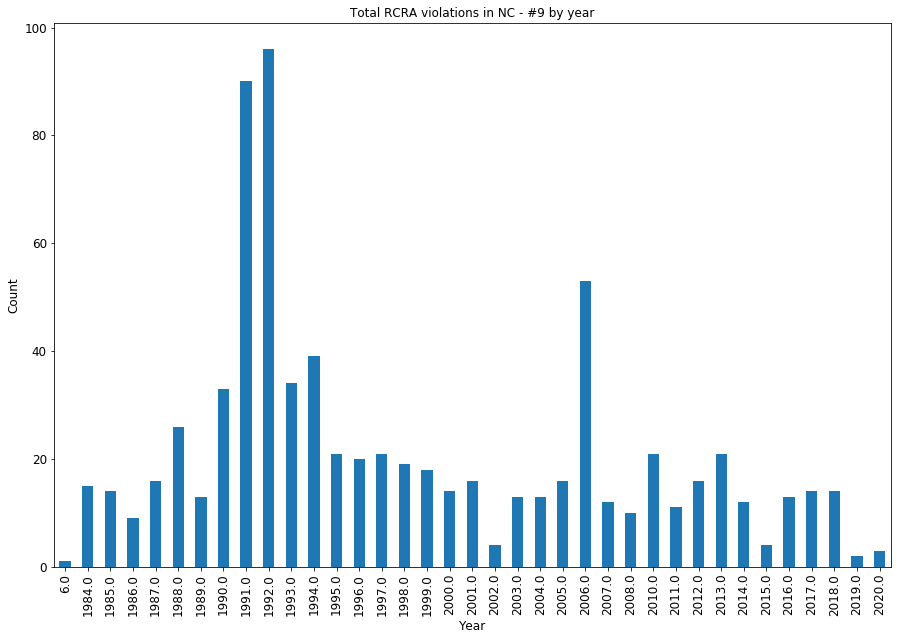

In [15]:
chart_title = "Total RCRA violations"

show_plot( cd_rcra, 'DATE_VIOLATION_DETERMINED', 'YEAR_VIOLATION', \
          my_state + ' - #' + str( my_cd ), '%m/%d/%Y', chart_title )

## Plot the number of violations by year, using the entire state.
Since the number of violations in a single CD may be small, it can be more
interesting to look at the entire state.

                YEAR_VIOLATION
YEAR_VIOLATION                
6                            1
1901                         3
1905                         1
1919                         3
1943                         2
1981                         2
1982                         1
1983                        39
1984                       269
1985                       223
1986                       174
1987                       354
1988                       375
1989                       363
1990                       432
1991                       824
1992                       760
1993                       492
1994                       736
1995                       768
1996                       241
1997                       343
1998                       396
1999                       320
2000                       261
2001                       276
2002                       257
2003                       340
2004                       315
2005                       295
2006    

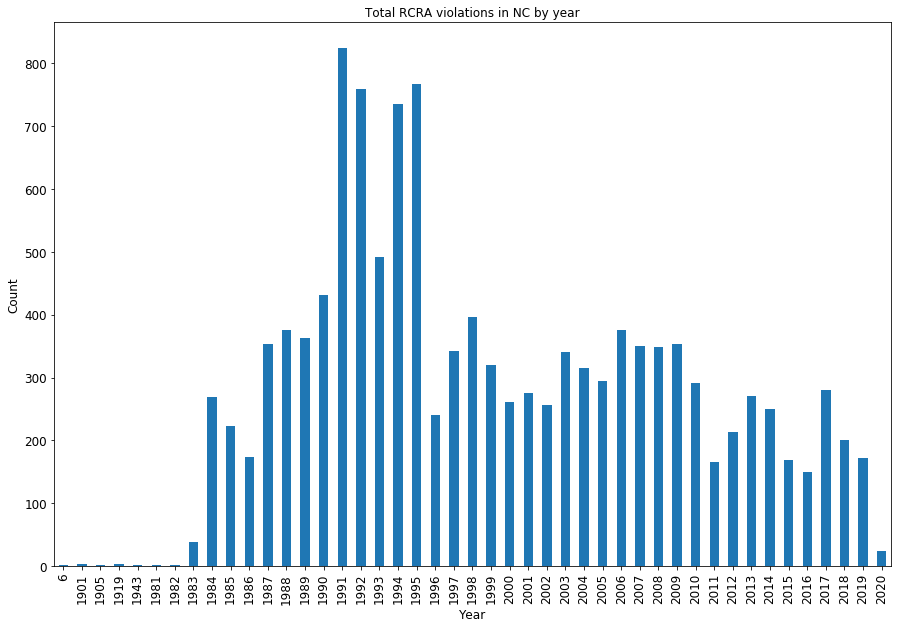

In [16]:
chart_title = "Total RCRA violations"

show_plot( rcra_data, 'DATE_VIOLATION_DETERMINED', 'YEAR_VIOLATION', \
          my_state, '%m/%d/%Y', chart_title )